In [360]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages


# Create Directory and Add Science Styles
plt.style.use(['science', 'ieee'])
plt.rcParams["text.usetex"] = False
plt.rcParams['figure.figsize'] = 6, 2
os.makedirs('plots', exist_ok=True)

# Window Size

In [361]:
window_size_f1 = [0.9938, 0.9942, 0.9938, 0.9945]
window_size_auc = [0.9973, 0.9975, 0.9973, 0.9976]
window_size_time = [8.9, 10.71, 11.9, 18.5]

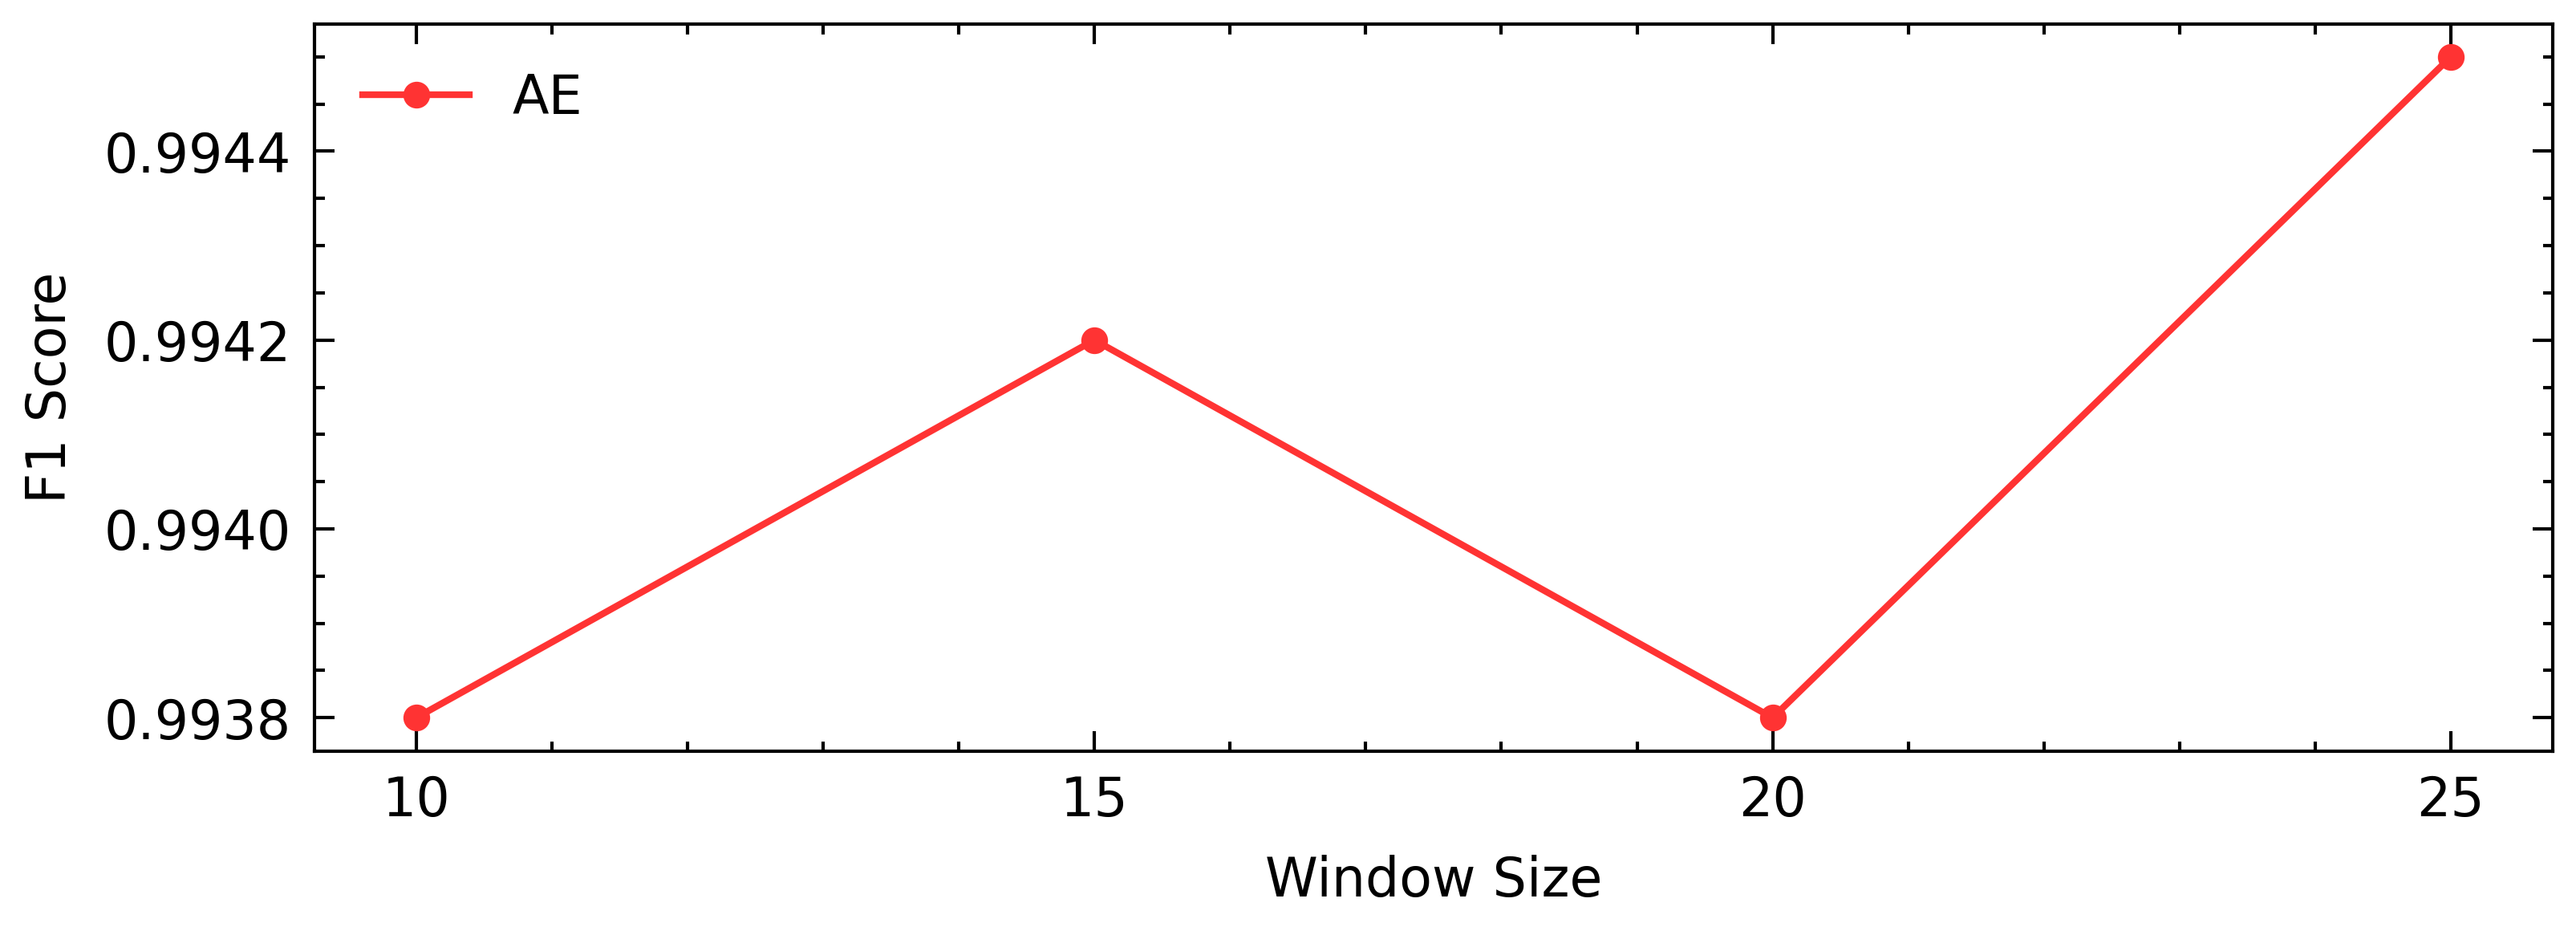

In [362]:
plt.figure(figsize=(6, 2))
plt.plot(window_size_f1, color='#FF3333', marker='.', linestyle='-', label='AE')
plt.xticks(range(len(window_size_f1)), [10, 15, 20, 25])
plt.xlabel('Window Size')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


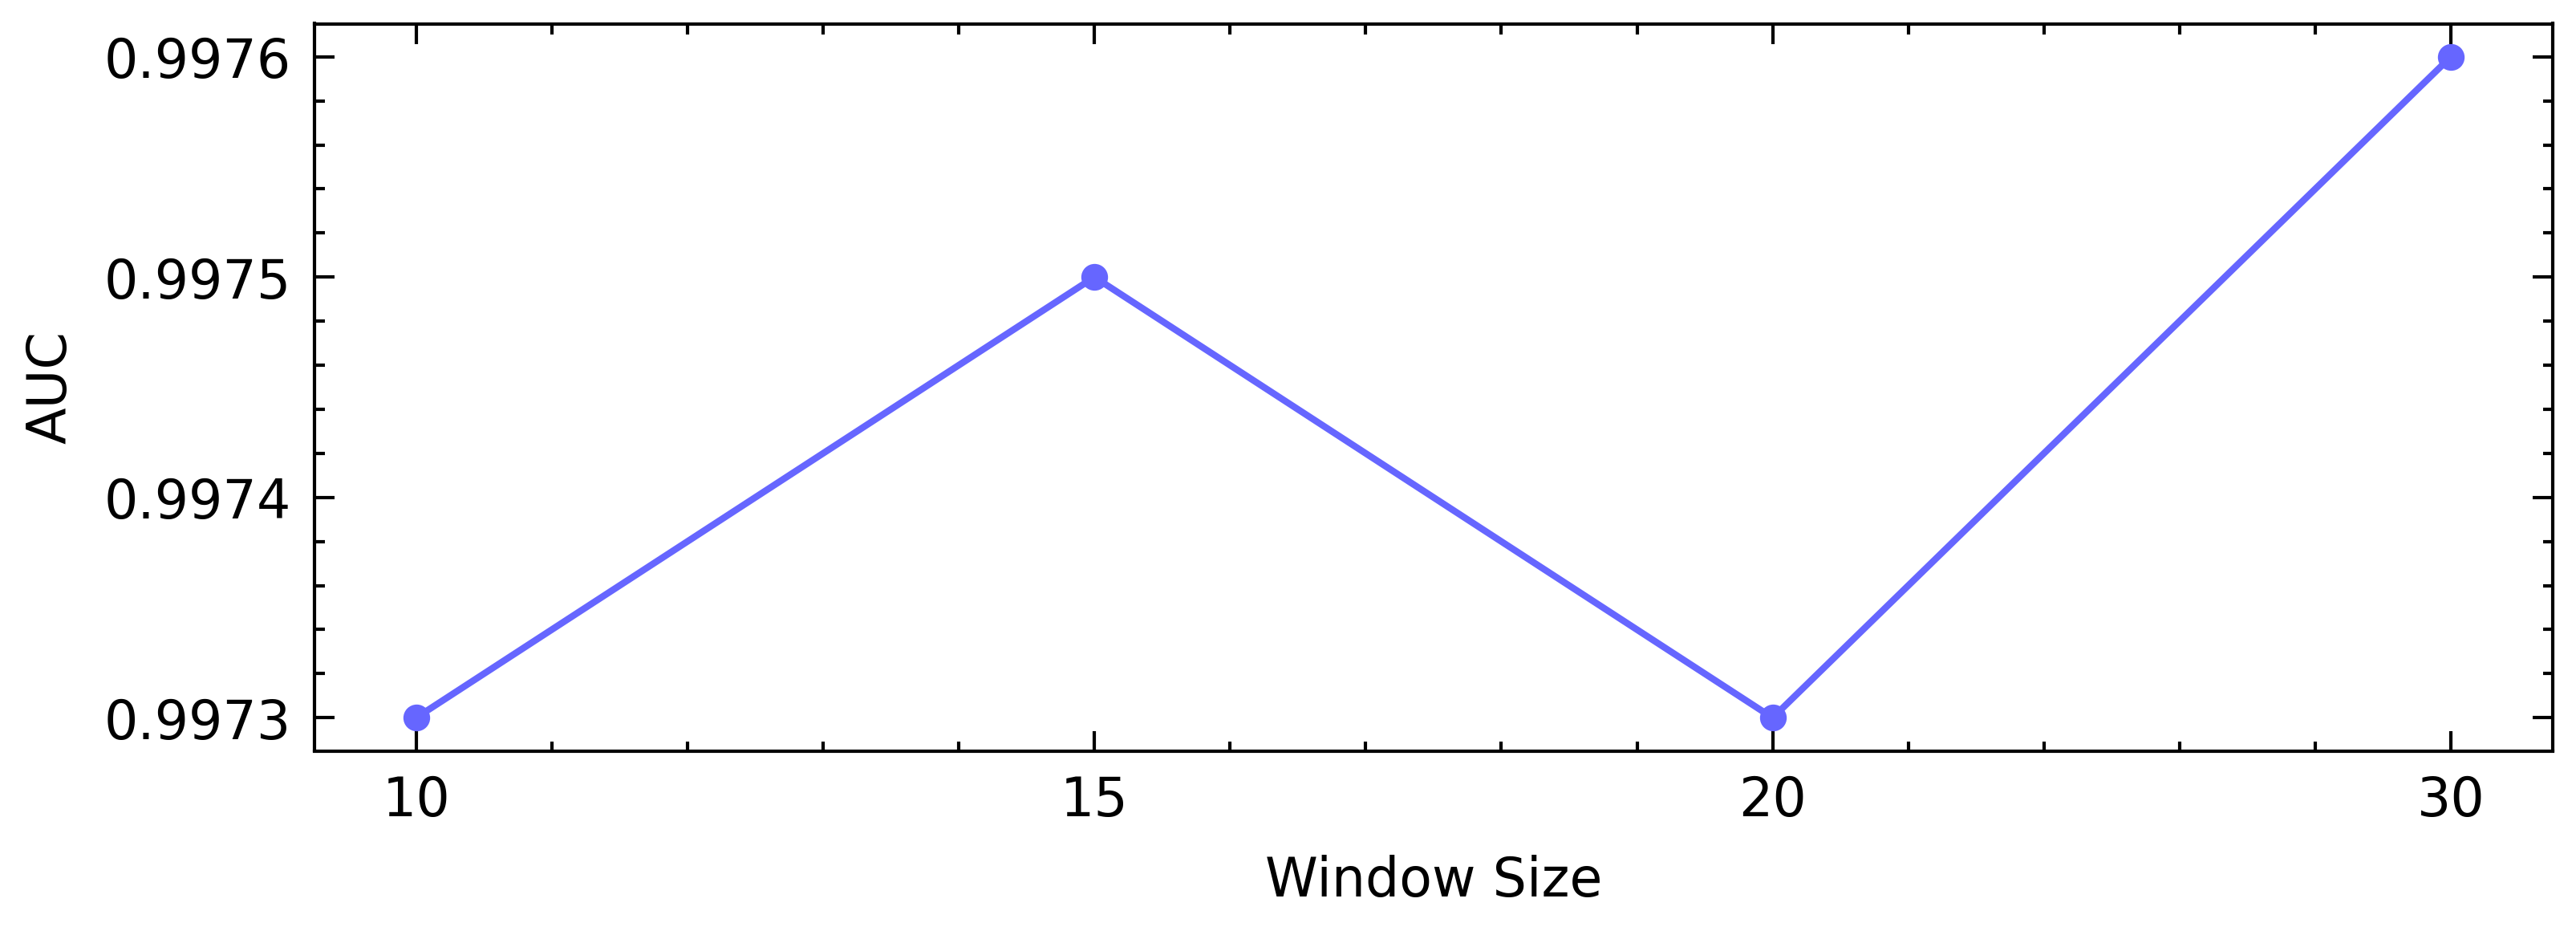

In [363]:
plt.figure(figsize=(6, 2))
plt.plot(window_size_auc, color='#6666FF', marker='.', linestyle='-')
plt.xticks(range(len(window_size_auc)), [10, 15, 20, 30])
plt.xlabel('Window Size')
plt.ylabel('AUC')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


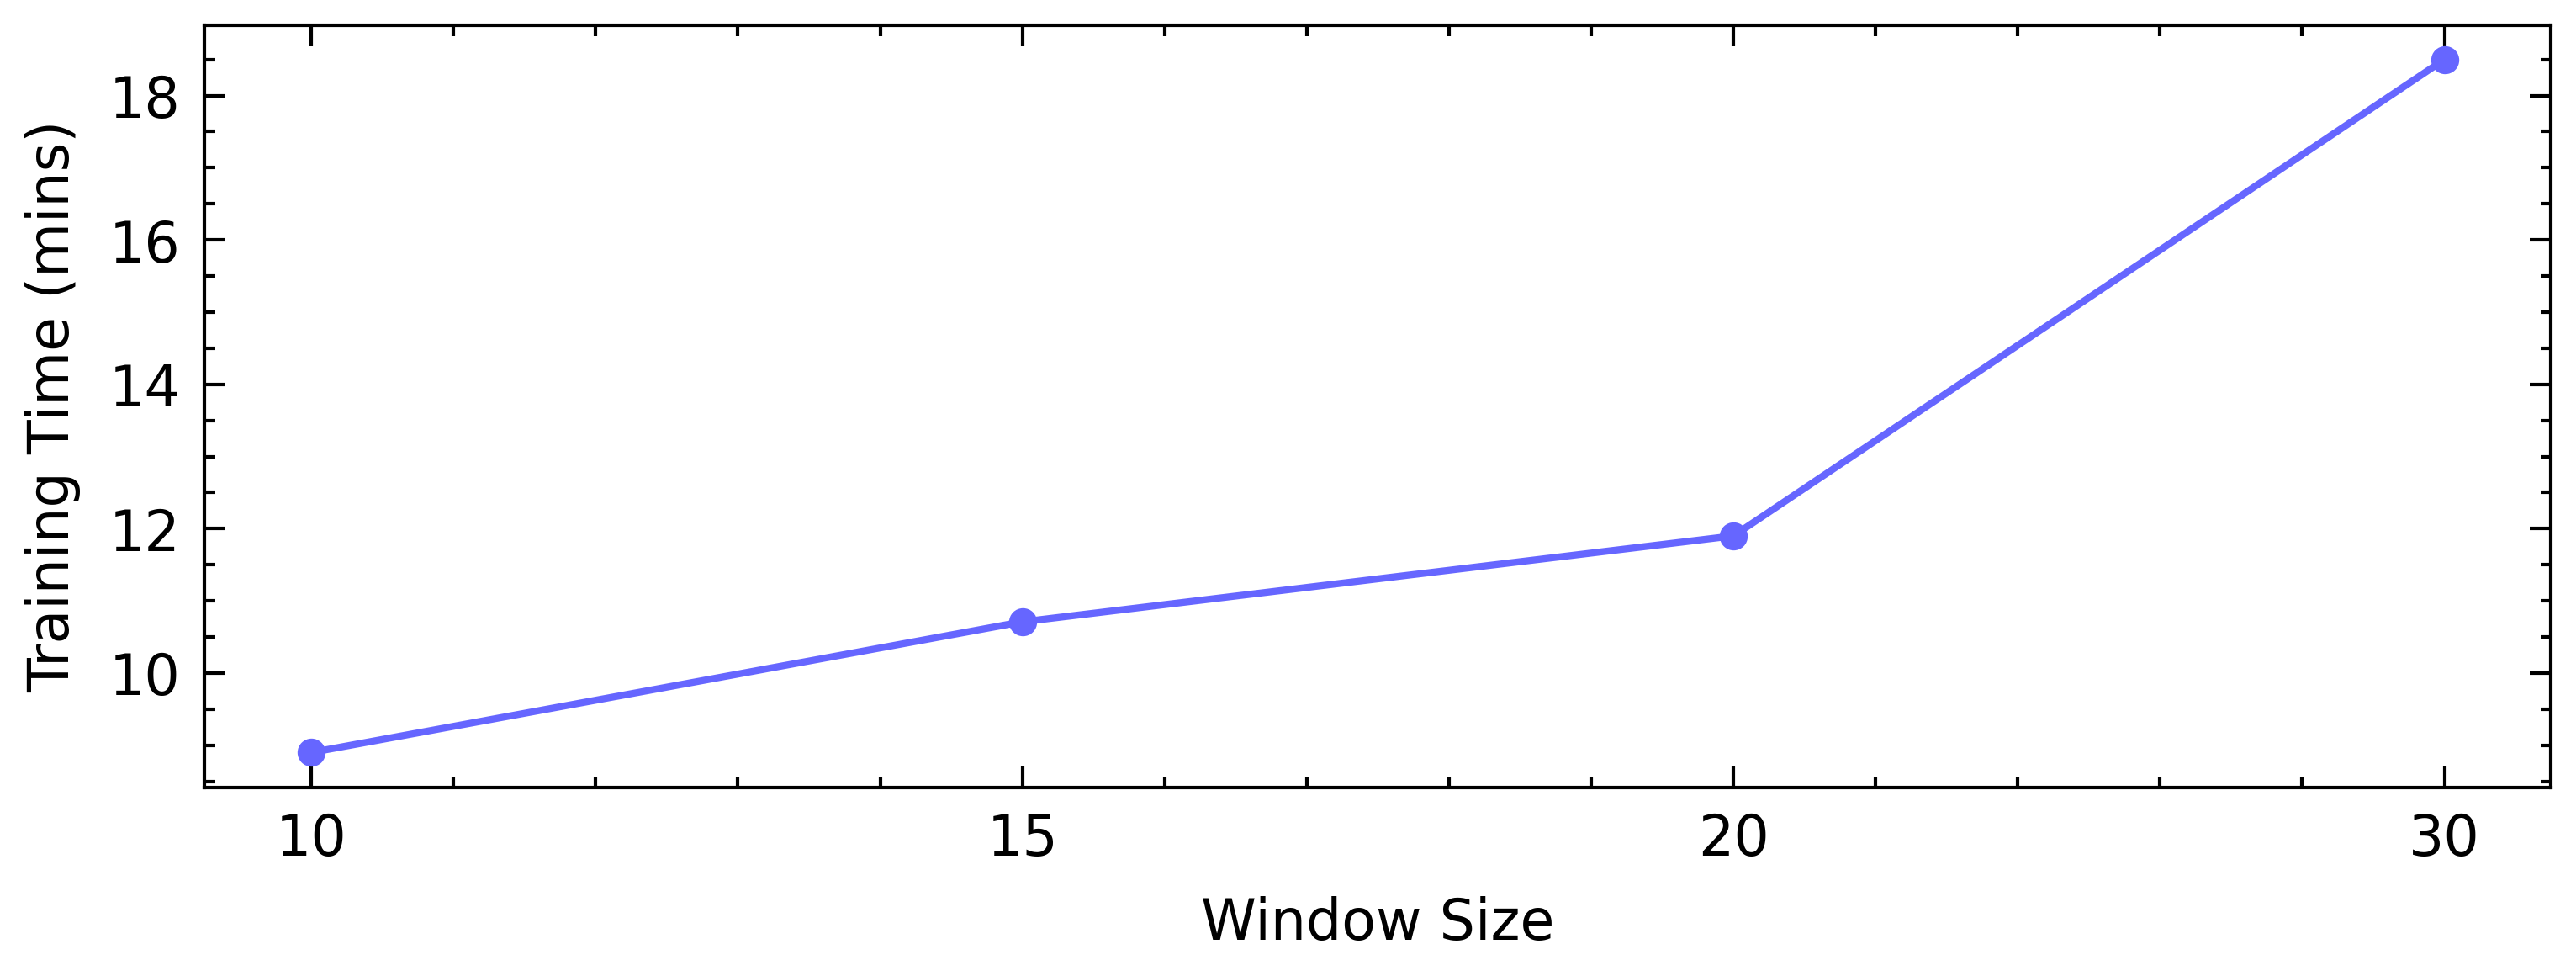

In [364]:
plt.figure(figsize=(6, 2))
plt.plot(window_size_time, color='#6666FF', marker='.', linestyle='-')
plt.xticks(range(len(window_size_time)), [10, 15, 20, 30])
plt.xlabel('Window Size')
plt.ylabel('Training Time (mins)')
plt.legend()
plt.show()

# Dataset Ratio

In [365]:
dataset_size_f1 = [0.2167, 0.4098, 0.9908, 0.9943]
dataset_size_auc = [0.5612, 0.6300, 0.9982, 0.9975]
dataset_size_time = [2.9, 5.78, 8.42, 11.16]
xticks = ['20%', '40%', '60%', '80%']

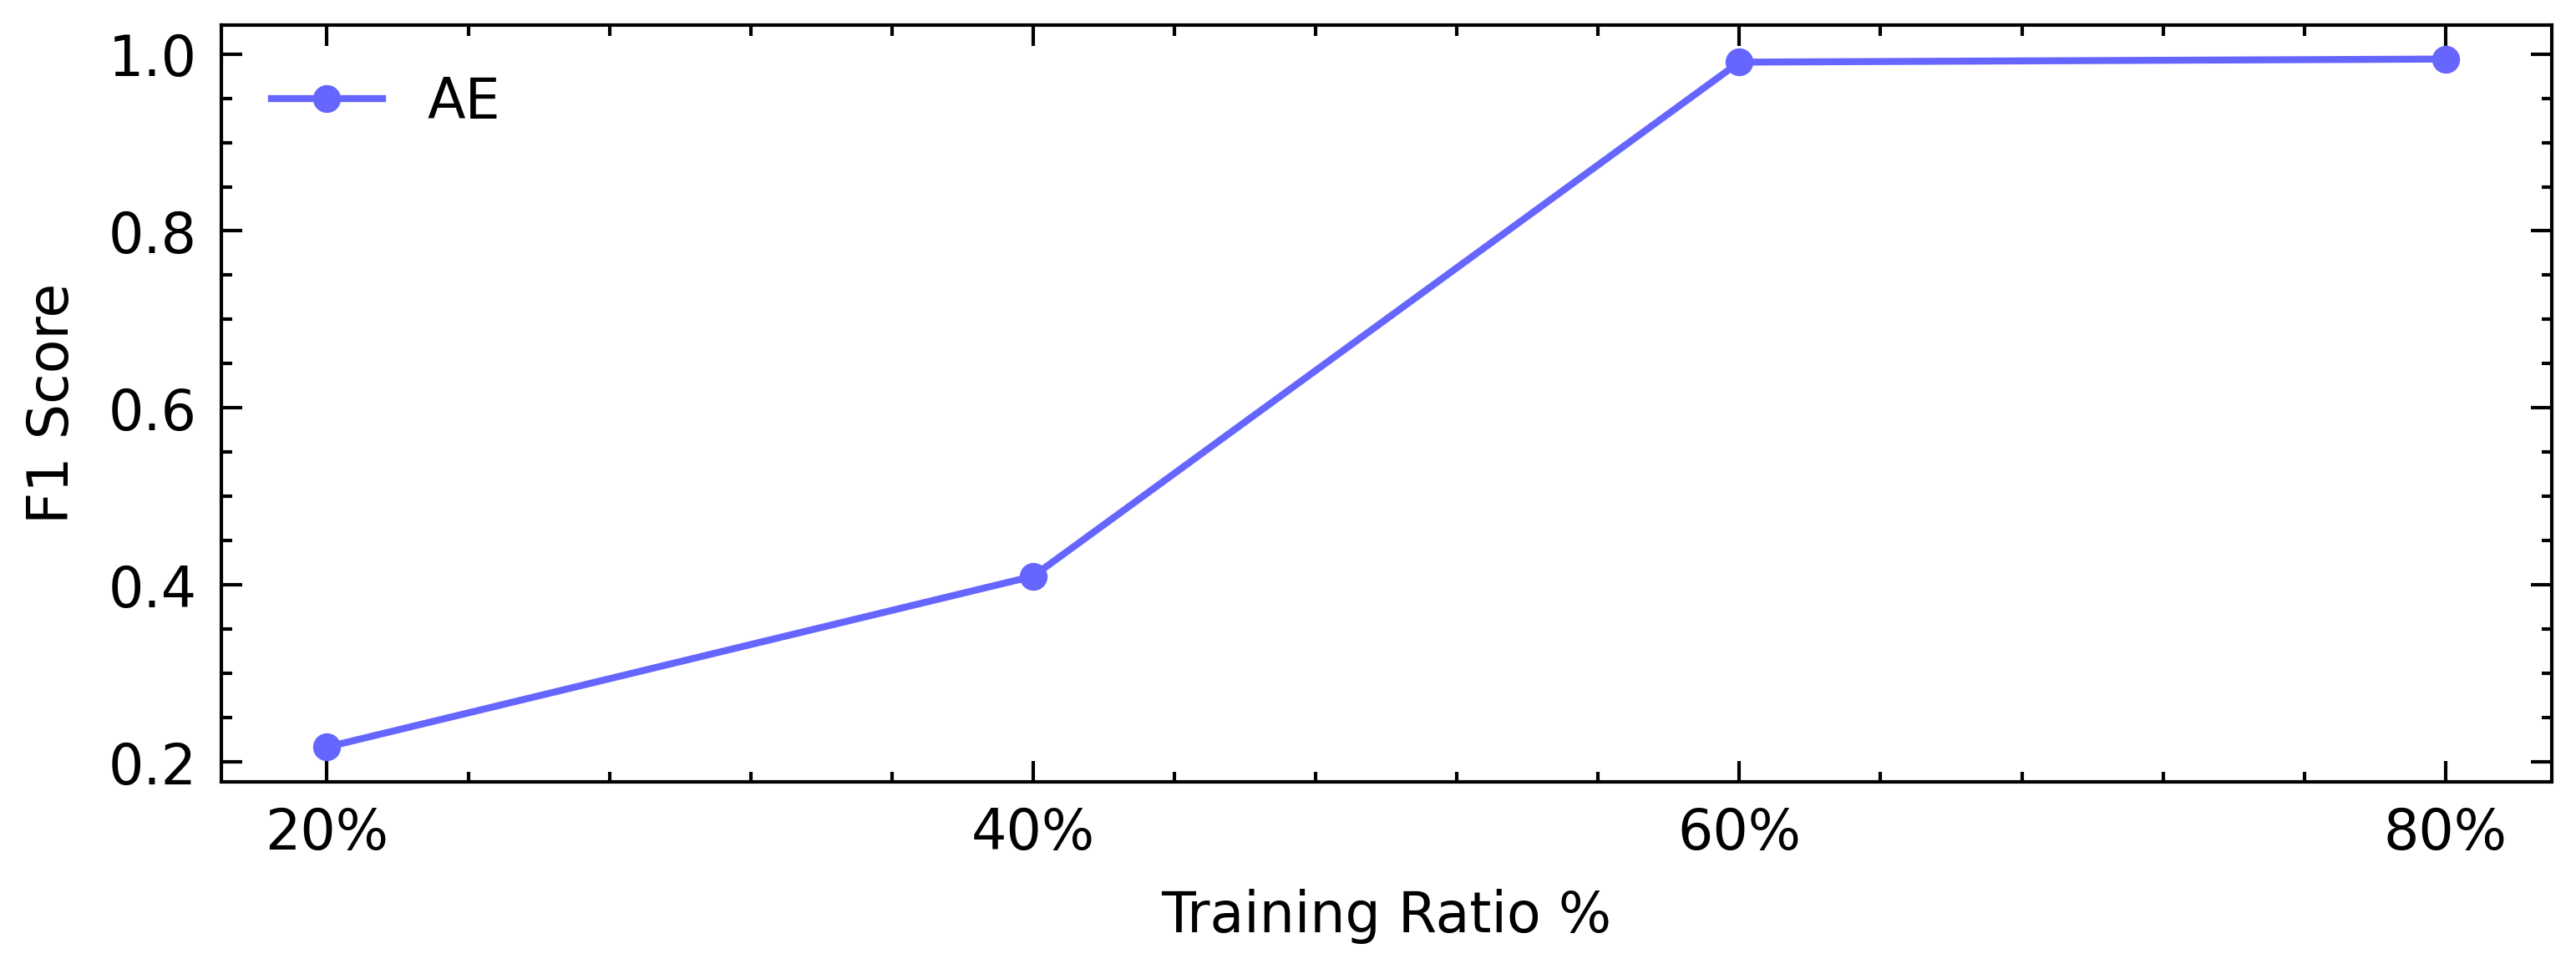

In [366]:
plt.figure(figsize=(6, 2))
plt.plot(dataset_size_f1, color='#6666FF', marker='.', linestyle='-', label='AE')
plt.xticks(range(len(xticks)), xticks)
plt.xlabel('Training Ratio %')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

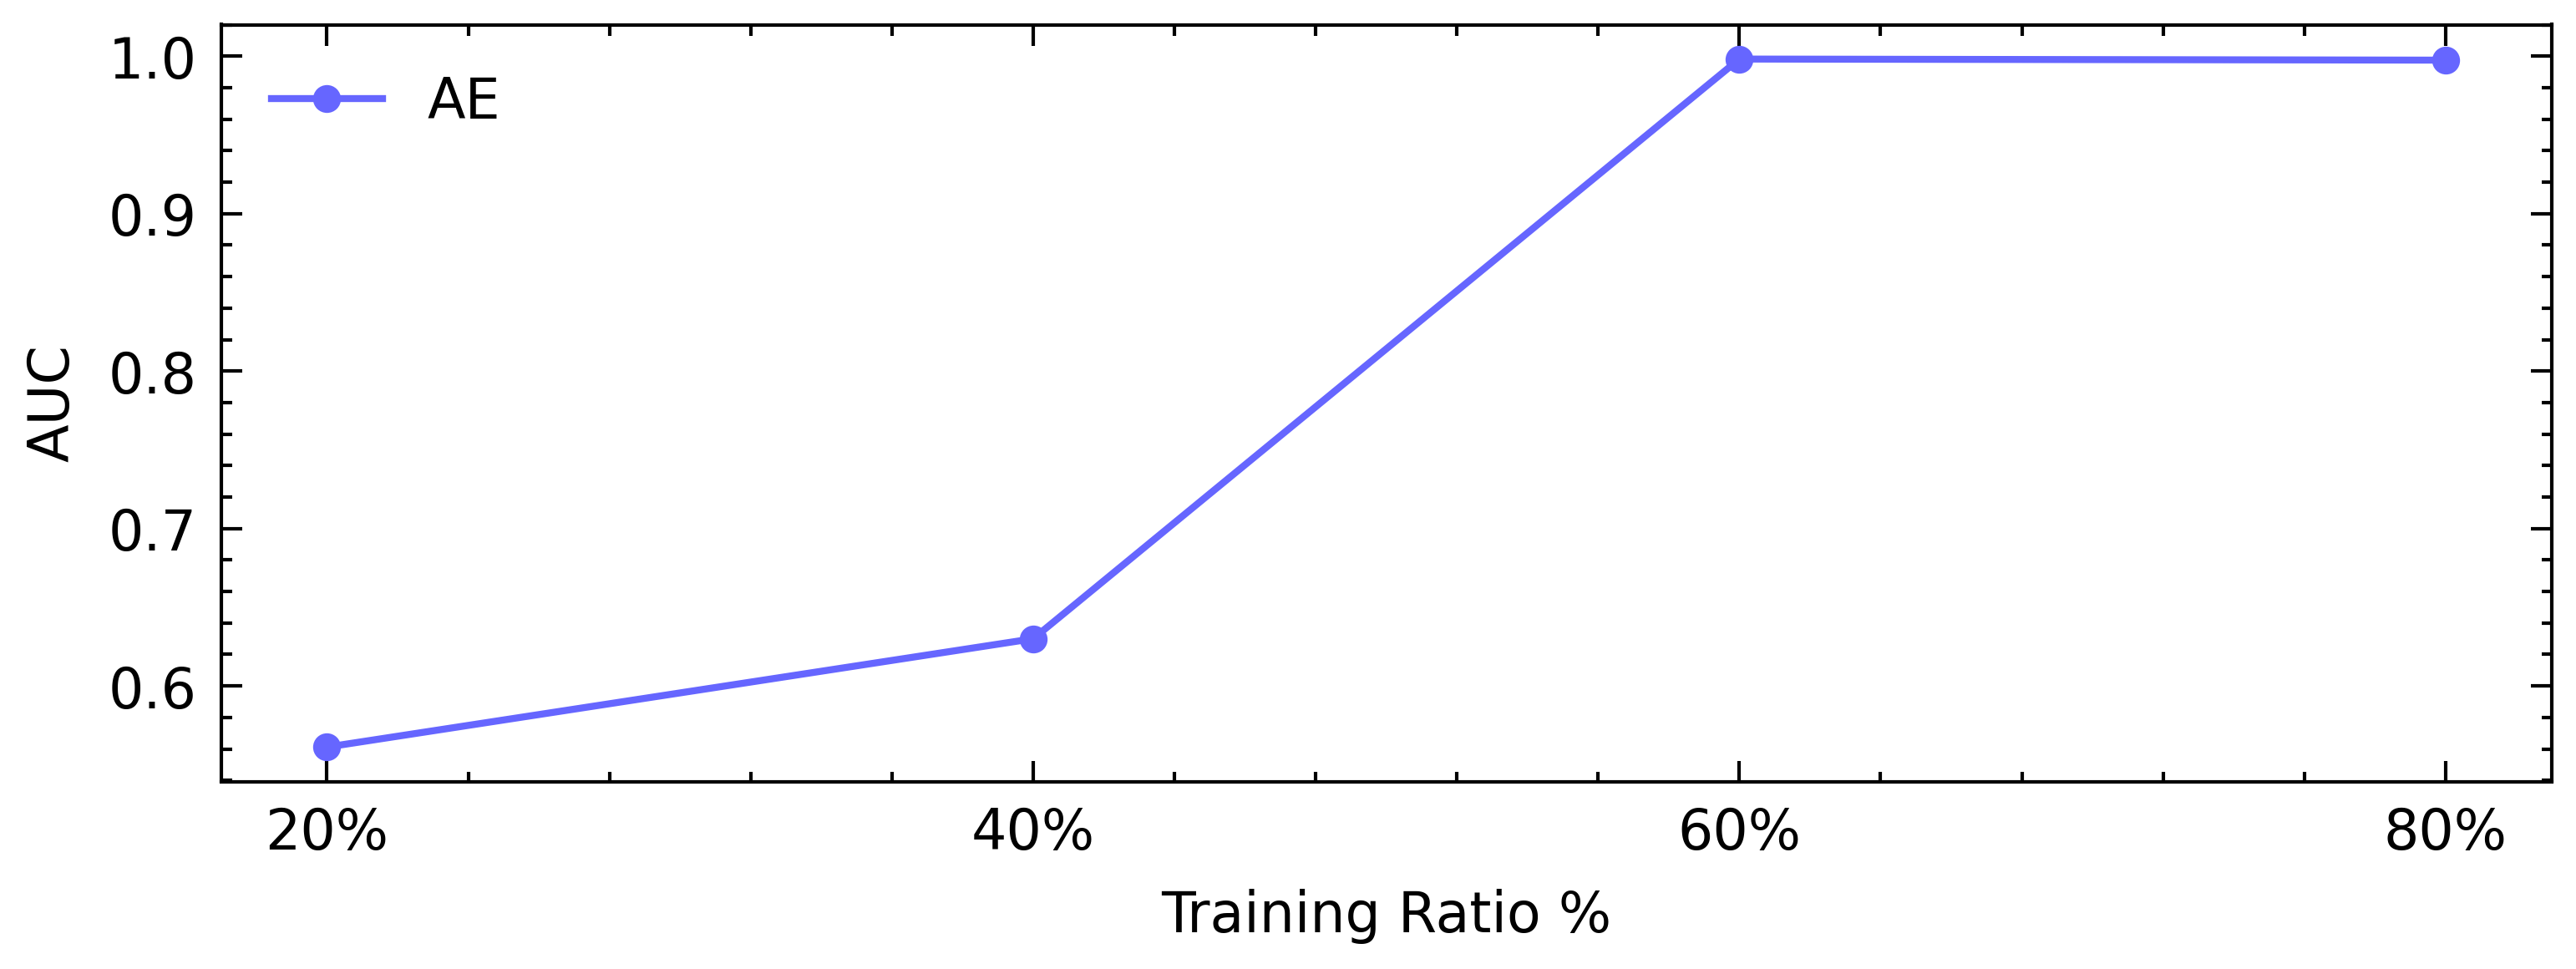

In [367]:
plt.figure(figsize=(6, 2))
plt.plot(dataset_size_auc, color='#6666FF', marker='.', linestyle='-', label='AE')
plt.xticks(range(len(xticks)), xticks)
plt.xlabel('Training Ratio %')
plt.ylabel('AUC')
plt.legend()
plt.show()

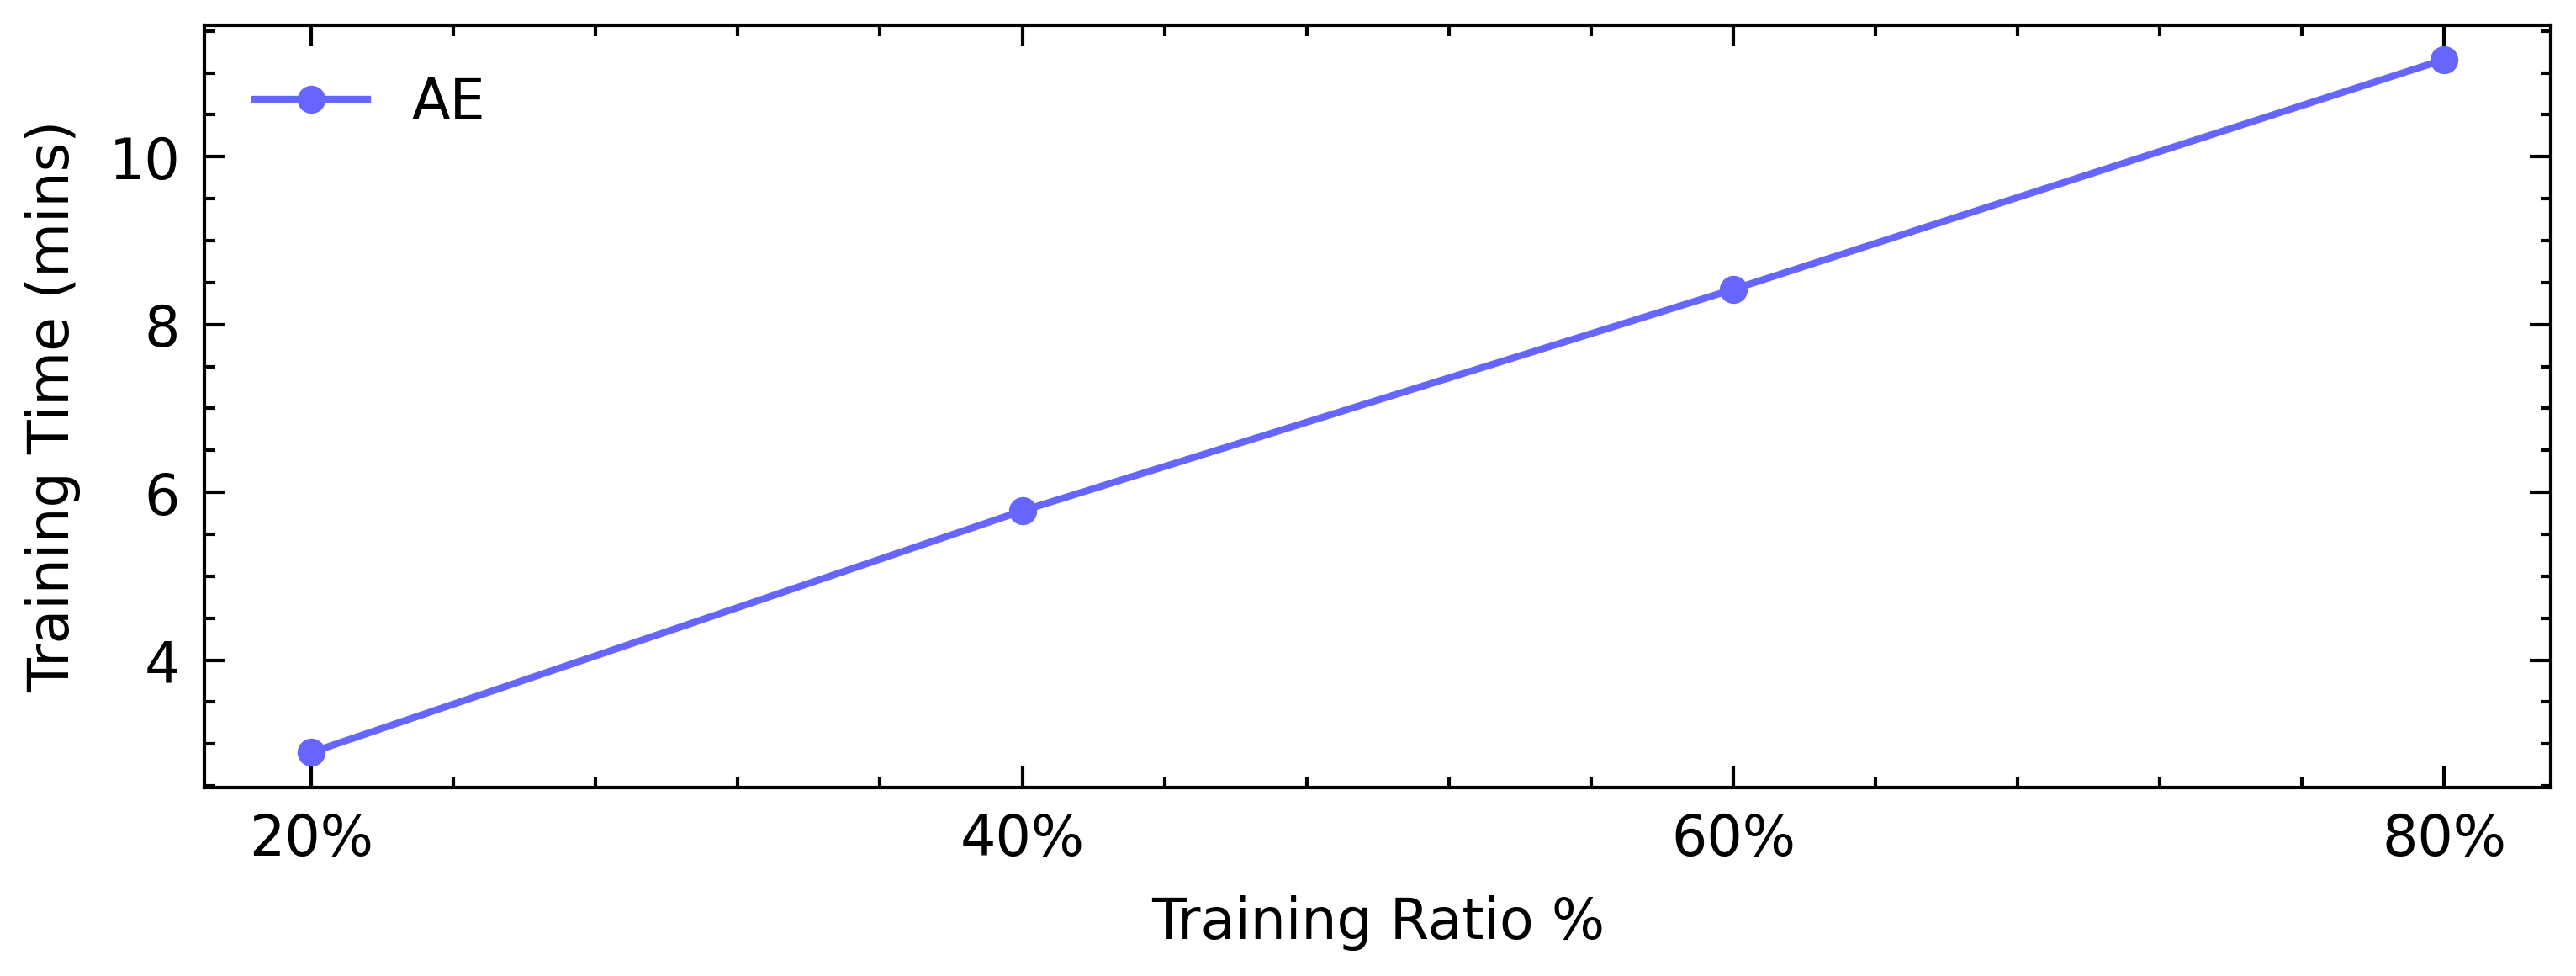

In [368]:
plt.figure(figsize=(6, 2))
plt.plot(dataset_size_time, color='#6666FF', marker='.', linestyle='-', label='AE')
plt.xticks(range(len(xticks)), xticks)
plt.xlabel('Training Ratio %')
plt.ylabel('Training Time (mins)')
plt.legend()
plt.show()

In [369]:
loss_distributed = [(1, 0.007995726075023413), (2, 0.007720753395309051), (3, 0.006061356669912736), (4, 0.005791679645578067), (5, 0.003349049249663949), (6, 0.0046305053401738405), (7, 0.002909042794878284), (8, 0.004172919162859519), (9, 0.004220400471240282), (10, 0.0037042145462085805), (11, 0.0036381978231171765), (12, 0.0037733128604789576), (13, 0.002396006602793932), (14, 0.0031342340322832265), (15, 0.003401408437639475), (16, 0.002734599867835641), (17, 0.002834363685299953), (18, 0.0029835276460895934), (19, 0.0021077191534762583), (20, 0.0023696079151704907)]
loss_centralized = [(1, 0.020210760723550273), (2, 0.011303629732734), (3, 0.008725262360476969), (4, 0.005981516964965785), (5, 0.008560867010390607), (6, 0.007766905067955909), (7, 0.006774382897183942), (8, 0.004810561217016303), (9, 0.004256123997490554), (10, 0.003709195523251828), (11, 0.004003889320249857), (12, 0.0034351156654717093), (13, 0.005076047909426907), (14, 0.003408550343251382), (15, 0.0030358956325444563), (16, 0.004681511773022285), (17, 0.003178977523989395), (18, 0.0028483440431487034), (19, 0.004328048165012598), (20, 0.004392531590954457)]

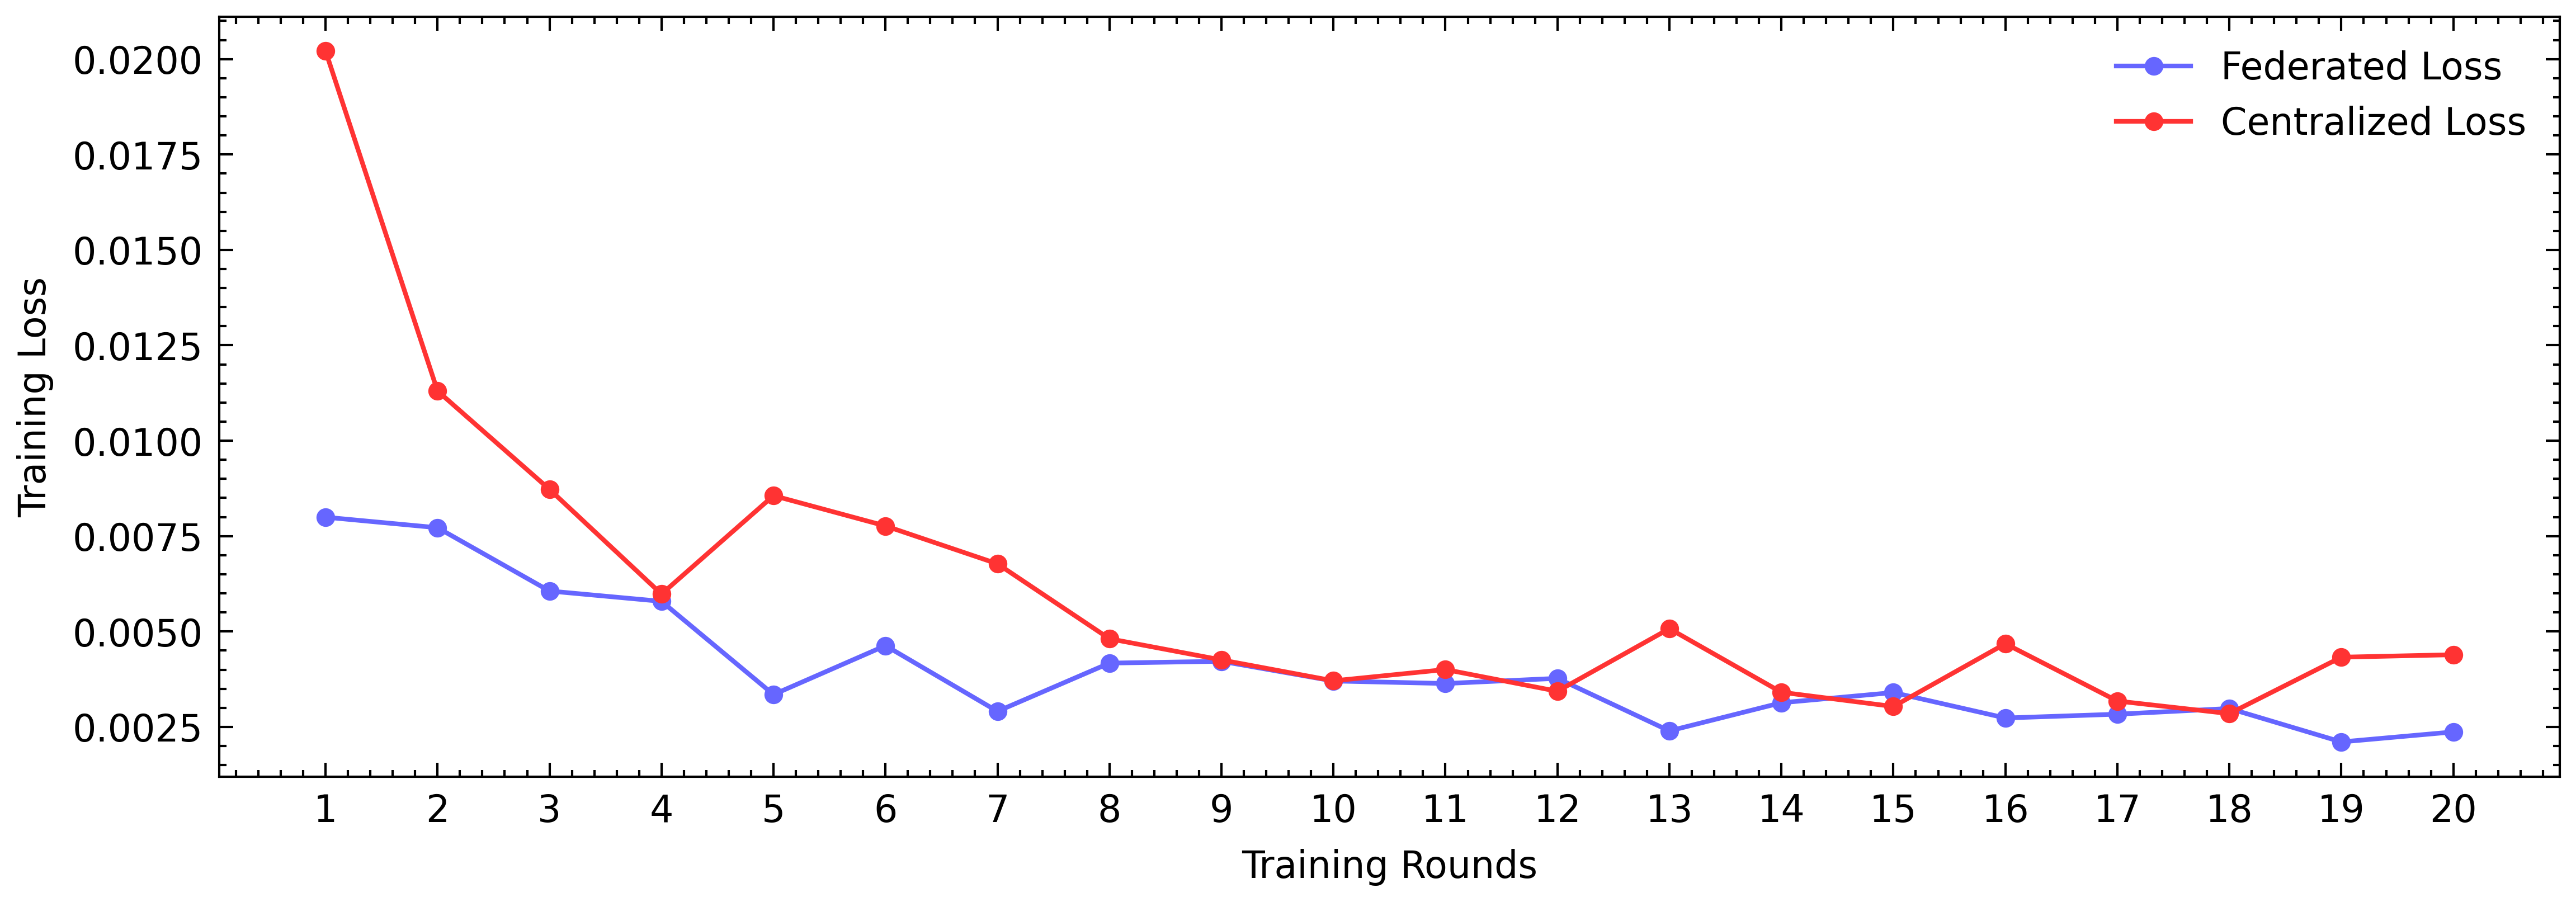

In [370]:
count = [i[0] for i in loss_distributed]
loss_dis = [i[1] for i in loss_distributed]
loss_cen = [i[1] for i in loss_centralized]
plt.figure(figsize=(9, 3))
plt.plot(loss_dis, color='#6666FF', marker='.', linestyle='-', label='Federated Loss')
plt.plot(loss_cen, color='#FF3333', marker='.', linestyle='-', label='Centralized Loss')
plt.xticks(range(len(count)), count)
plt.xlabel('Training Rounds')
plt.ylabel('Training Loss')
plt.legend()
plt.show()

# Evaluation of each device

In [371]:
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import DataLoader
from codes.evaluations.eval_utils import *
from codes.plotter import *

config = {
    "num_epochs": 20,
    "learning_rate": 0.0001,
    "weight_decay": 1e-5,
    "num_window": 15,
}

In [372]:
def load_model(modelname, dims, config):
    import codes.models
    model_class = getattr(codes.models, modelname)
    model = model_class(dims, config).double()
    optimizer = torch.optim.AdamW(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5, 0.9)
    fname = f'checkpoints/FLAE_ENERGY/model.ckpt'
    if os.path.exists(fname):
        print(f"Loading pre-trained model: {model.name}")
        checkpoint = torch.load(fname)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        # accuracy_list = checkpoint['accuracy_list']
    return model, optimizer, scheduler

In [373]:
def load_dataset(dataset, cid, filter=True):
    if filter:
        folder = os.path.join(f'data/processed/{dataset}/filtered/{cid}')
    else:
        folder = os.path.join('data/processed', dataset)
    if not os.path.exists(folder):
        raise Exception('Processed Data not found.')
    loader = []
    for file in ['train', 'test', 'labels']:
        loader.append(np.load(os.path.join(folder, f'{file}.npy')))
    _train_loader = DataLoader(loader[0], batch_size=loader[0].shape[0])
    _test_loader = DataLoader(loader[1], batch_size=loader[1].shape[0])
    _labels = loader[2]
    return _train_loader, _test_loader, _labels

def convert_to_windows(data, model):
    windows = []
    w_size = model.n_window
    for i, _ in enumerate(data):
        if i >= w_size:
            w = data[i - w_size:i]
        else:
            w = torch.cat([data[0].repeat(w_size - i, 1), data[0:i]])
        windows.append(w.view(-1))
    return torch.stack(windows)

In [374]:
def backprop(epoch, model, data, dataO, optimizer, scheduler, training=True):
    l = nn.MSELoss(reduction='mean' if training else 'none')
    feats = dataO.shape[1]
    if 'AE' in model.name:
        l = nn.MSELoss(reduction = 'none')
        l1 = nn.L1Loss(reduction = 'none')
        n = epoch + 1
        l1s = []
        if training:
            for _, d in enumerate(data):
                x = model(d)
                loss = torch.mean(l(x, d))
                l1s.append(torch.mean(loss).item())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            scheduler.step()
            tqdm.write(f'Epoch {epoch + 1},\tMSE = {np.mean(l1s)}')
            return np.mean(l1s), optimizer.param_groups[0]['lr']
        else:
            xs = []
            for d in data: 
                x = model(d)
                xs.append(x)
            xs = torch.stack(xs)
            y_pred = xs[:, data.shape[1]-feats:data.shape[1]].view(-1, feats)
            loss = l(xs, data)
            loss = loss[:, data.shape[1]-feats:data.shape[1]].view(-1, feats)
            mae = l1(xs, data)
            mae = mae[:, data.shape[1]-feats:data.shape[1]].view(-1, feats)
            return loss.detach().numpy(), mae.detach().numpy(), y_pred.detach().numpy()
    else:
        y_pred = model(data)
        loss = l(y_pred, data)
        if training:
            tqdm.write(f'Epoch {epoch},\tMSE = {loss}')
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            return loss.item(), optimizer.param_groups[0]['lr']
        else:
            return loss.detach().numpy(), y_pred.detach().numpy()
        

In [375]:
device = 'dev5'

In [376]:
train_loader, test_loader, labels = load_dataset('ENERGY', device, filter=True)
model, optimizer, scheduler = load_model('AE', labels.shape[1], config)
## Prepare data
trainD, testD = next(iter(train_loader)), next(iter(test_loader))
trainO, testO = trainD, testD
if model.name in ['AE']:
    trainD, testD = convert_to_windows(trainD, model), convert_to_windows(testD, model)
### Testing phase
torch.zero_grad = True
model.eval()
with torch.no_grad():
    loss, mae, y_pred = backprop(0, model, testD, testO, optimizer, scheduler, training=False)
    ### Scores
    plot_actual_predicted('FLAE_ENERGY', testO, y_pred)
    lossT, _, _ = backprop(0, model, trainD, trainO, optimizer, scheduler, training=False)
    for i in range(loss.shape[1]):
        lt, l, ls = lossT[:, i], loss[:, i], labels[:, i]
        result, _ = pot_eval(lt, l, ls)
        
    lossTfinal, lossFinal = np.mean(lossT, axis=1), np.mean(loss, axis=1)
    labelsFinal = (np.sum(labels, axis=1) >= 1) + 0
    
    result, _ = pot_eval(lossTfinal, lossFinal, labelsFinal)
    
    print(result)
    print("MAE: ", np.mean(mae))
    print("MSE: ", np.mean(loss))

Loading pre-trained model: AE
Error 
{'f1': 0.31406767918463346, 'precision': 0.9920634133283005, 'recall': 0.18656716139451998, 'TP': 125, 'TN': 2976, 'FP': 1, 'FN': 545, 'ROC/AUC': 0.5931156277731263, 'threshold': 0.08335224677974679}
MAE:  0.05210357108367217
MSE:  0.005661306308545818


<Figure size 3600x1200 with 0 Axes>

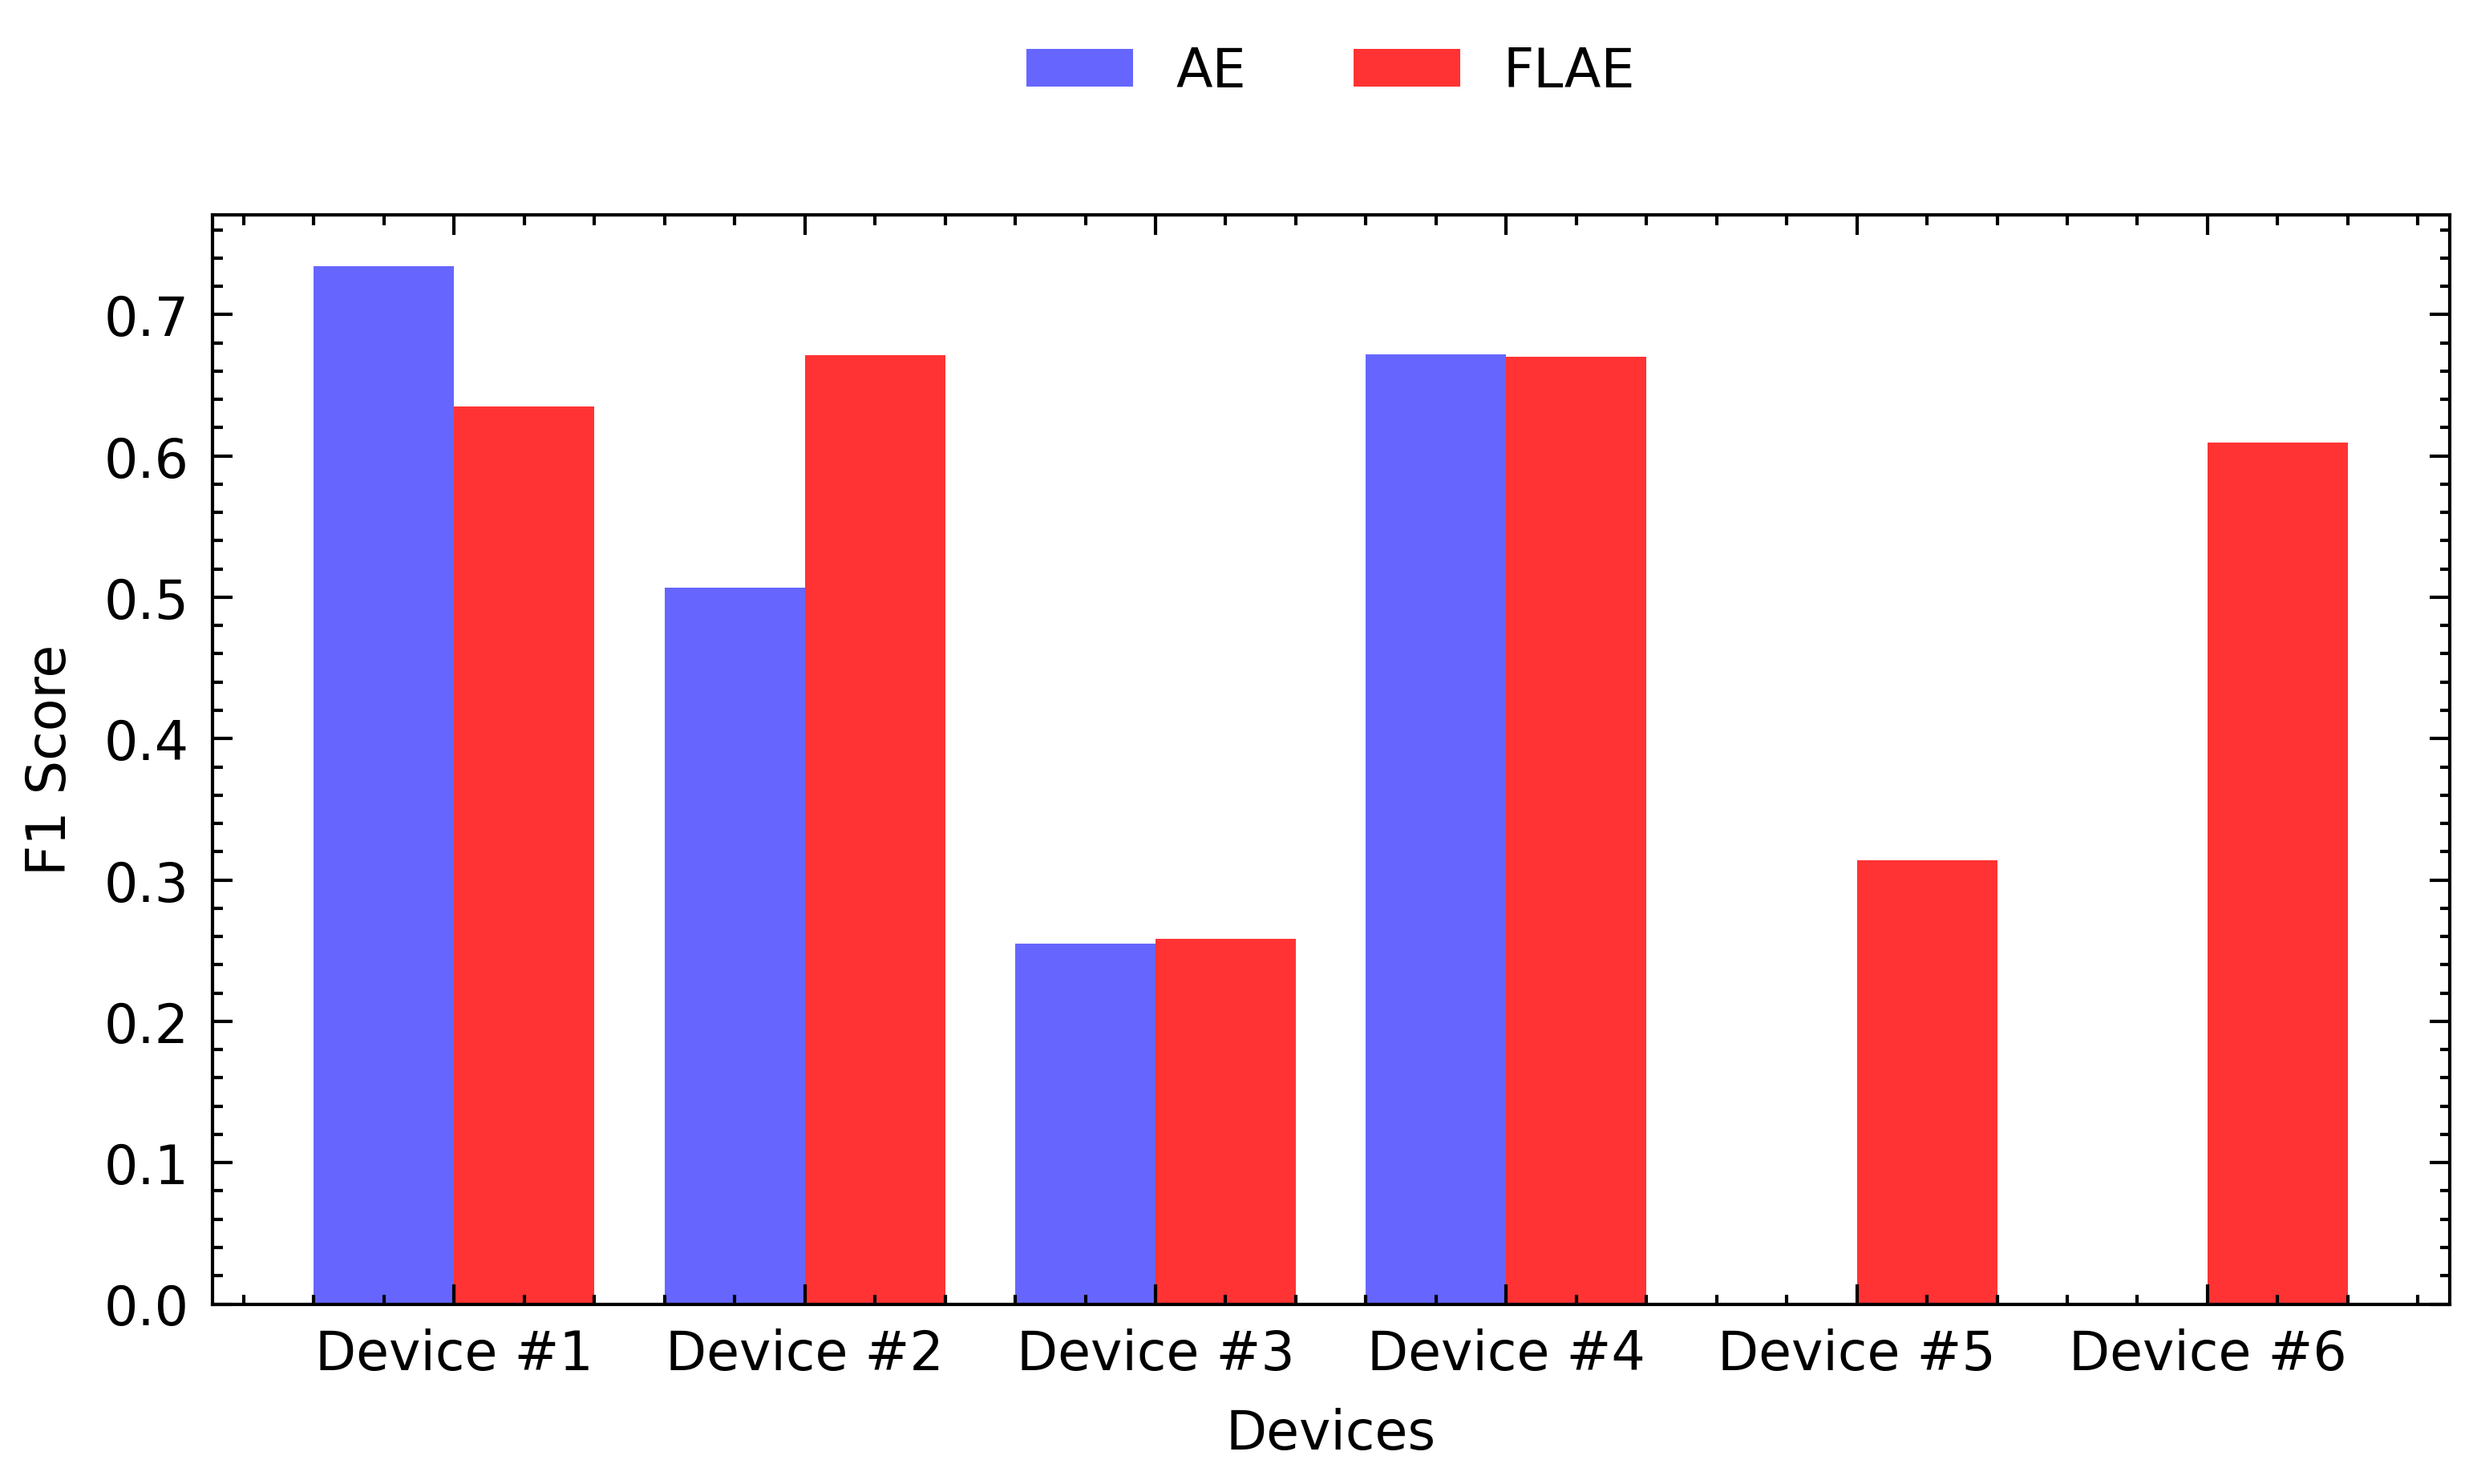

In [399]:
devices = ['Device #1', 'Device #2', 'Device #3', 'Device #4', 'Device #5', 'Device #6']

f1_ae = [0.7341, 0.5066, 0.2552, 0.6719, 0.0, 0.0]
f1_flae = [0.6350, 0.6712, 0.2583, 0.6699, 0.3140, 0.6093]
  
X_axis = np.arange(len(devices))

plt.figure(figsize=(6, 3))
  
plt.bar(X_axis - 0.2, f1_ae, 0.4, color='#6666ff', label = 'AE')
plt.bar(X_axis + 0.2, f1_flae, 0.4, color='#ff3333', label = 'FLAE')
  
plt.xticks(X_axis, devices)
plt.xlabel("Devices")
plt.ylabel("F1 Score")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2)
plt.show()

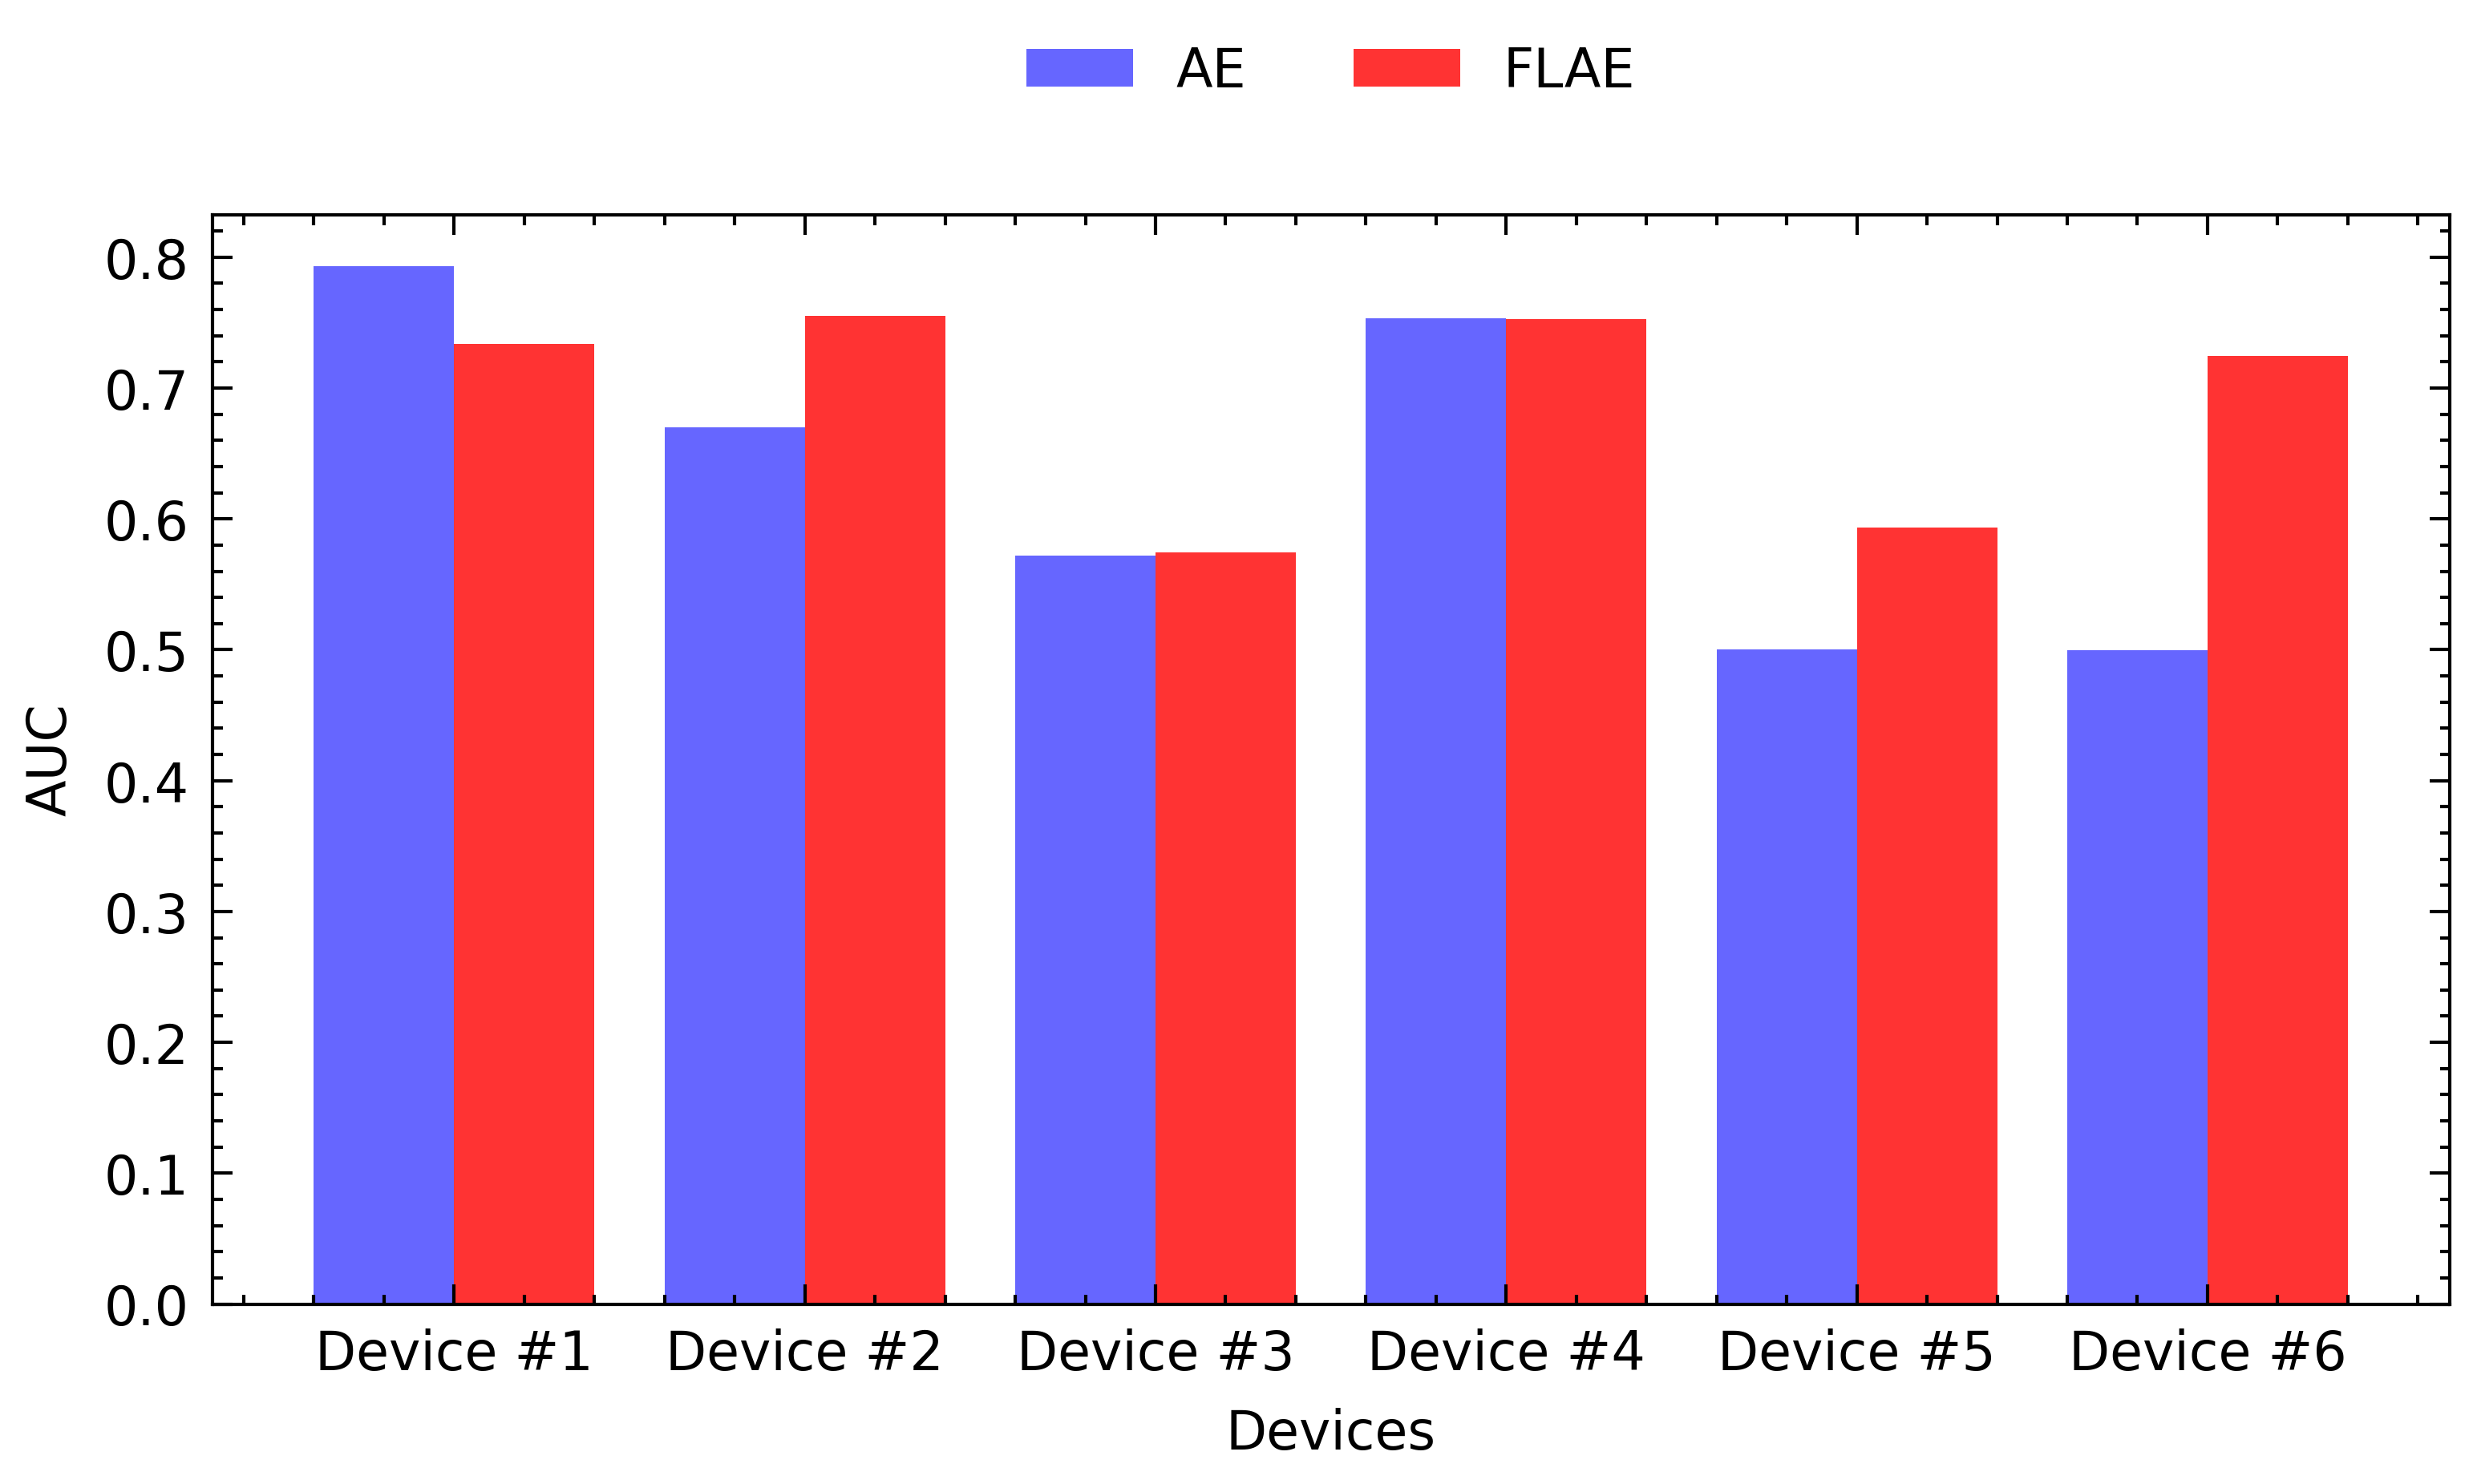

In [400]:
devices = ['Device #1', 'Device #2', 'Device #3', 'Device #4', 'Device #5', 'Device #6']

auc_ae = [0.7930, 0.6700, 0.5720, 0.7534, 0.5, 0.4996]
auc_flae = [0.7339, 0.7549, 0.5741, 0.7529, 0.5931, 0.7246]
  
X_axis = np.arange(len(devices))

plt.figure(figsize=(6, 3))
  
plt.bar(X_axis - 0.2, auc_ae, 0.4, color='#6666ff', label = 'AE')
plt.bar(X_axis + 0.2, auc_flae, 0.4, color='#ff3333', label = 'FLAE')
  
plt.xticks(X_axis, devices)
plt.xlabel("Devices")
plt.ylabel("AUC")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2)
plt.show()